In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb

import folium
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.ensemble import AdaBoostRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor # RMSE 
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN

In [16]:
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', None)

In [17]:
area = pd.read_csv("frequent_area.csv", encoding = 'cp949')
area

,장소설명,시도,시군구,지역,위도,경도
0,경기도 수원시 장안구 연무동(퉁소바위사거리 부근),경기,수원시,경기 수원시,37.291866,127.028769
1,경기도 수원시 장안구 영화동(영화초교사거리 부근),경기,수원시,경기 수원시,37.295078,127.016335
2,경기도 수원시 권선구 세류동(터미널사거리 부근),경기,수원시,경기 수원시,37.249954,127.018655
3,경기도 수원시 권선구 권선동(매탄권선역사거리 부근),경기,수원시,경기 수원시,37.251760,127.041167
4,경기도 수원시 권선구 서둔동(서둔교차로 부근),경기,수원시,경기 수원시,37.269280,126.993927
...,...,...,...,...,...,...
374,서울 송파구 가락동(가락시장역교차로 부근),서울,송파구,서울 송파구,37.492502,127.118637
375,서울 송파구 잠실동(서울종합운동장교차로 부근),서울,송파구,서울 송파구,37.510616,127.070612
376,서울 송파구 잠실동(종합운동장사거리 부근),서울,송파구,서울 송파구,37.512052,127.079645
377,서울 송파구 장지동(복정역교차로 부근),서울,송파구,서울 송파구,37.470768,127.126755


In [18]:
area['지역'].unique()

array(['경기 수원시', '경기 성남시', '경기 부천시', '경기 평택시', '경기 안산시', '경기 고양시',
       '경기 용인시', '경기 화성시', '충청북도 청주시', '전라북도 전주시', '경상남도 창원시', '전라남도 목포시',
       '전라남도 여수시', '전라남도 나주시', '대전 서구', '부산 강서구', '서울 송파구'], dtype=object)

In [19]:
cctv = pd.read_csv("신호위반_민원_단속카메라_전처리후.csv", encoding = 'cp949')

In [20]:
cctv = cctv[cctv['지역'].isin(['경기 수원시', '경기 성남시', '경기 부천시', '경기 평택시', '경기 안산시', '경기 고양시',
       '경기 용인시', '경기 화성시', '충청북도 청주시', '전라북도 전주시', '경상남도 창원시', '전라남도 목포시',
       '전라남도 여수시', '전라남도 나주시', '대전 서구', '부산 강서구'])]

In [21]:
cctv

,위도,경도,구분,시도,시군구,지역
441,36.320997,127.344114,신호위반 단속카메라,대전,서구,대전 서구
507,34.796201,126.385903,신호위반 단속카메라,전라남도,목포시,전라남도 목포시
509,34.794657,126.408119,신호위반 단속카메라,전라남도,목포시,전라남도 목포시
510,34.830596,126.418480,신호위반 단속카메라,전라남도,목포시,전라남도 목포시
512,34.799023,126.429173,신호위반 단속카메라,전라남도,목포시,전라남도 목포시
...,...,...,...,...,...,...
79909,34.822069,126.397339,신호위반 민원,전라남도,목포시,전라남도 목포시
79910,34.822033,126.397306,신호위반 민원,전라남도,목포시,전라남도 목포시
79919,34.758059,127.671561,신호위반 민원,전라남도,여수시,전라남도 여수시
79921,34.849600,127.683960,신호위반 민원,전라남도,여수시,전라남도 여수시


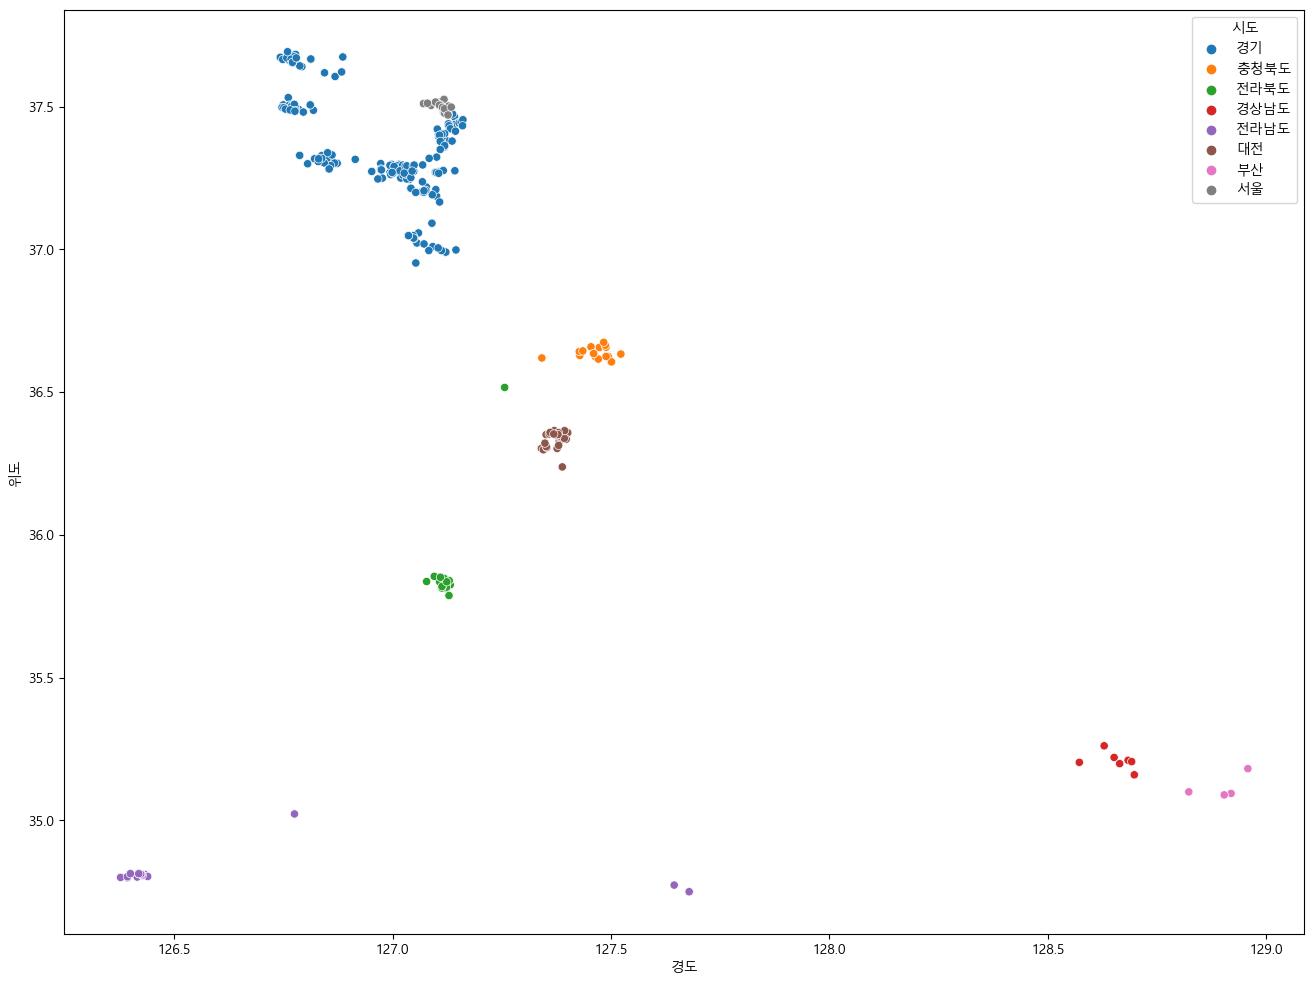

In [22]:
plt.figure(figsize=(16, 12))
sns.scatterplot(data=area, x="경도", y="위도", hue="시도")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.show()

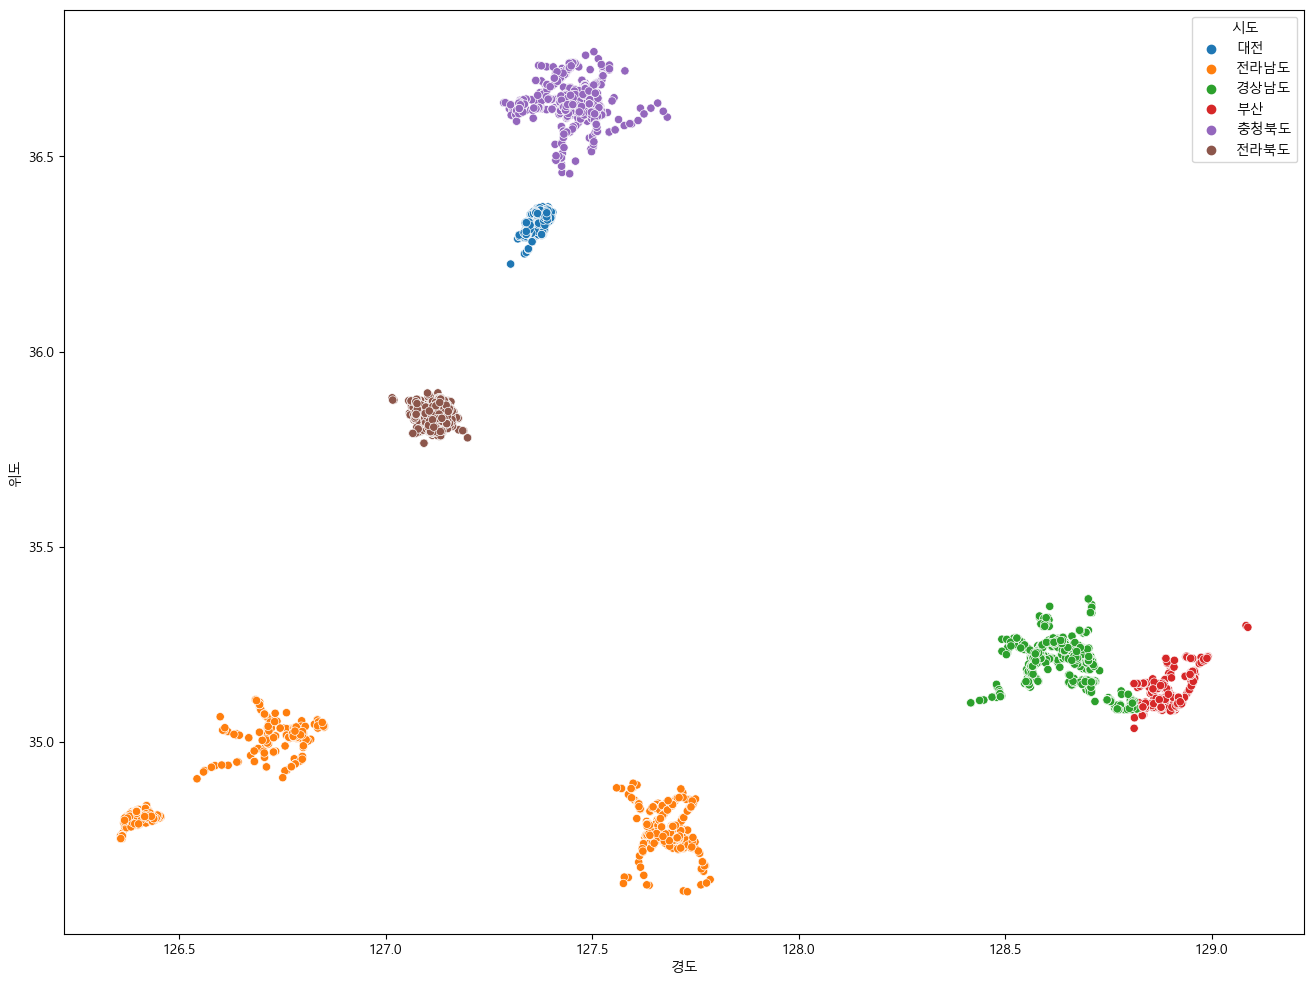

In [23]:
plt.figure(figsize=(16, 12))
sns.scatterplot(data=cctv, x="경도", y="위도", hue="시도")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.show()

In [24]:
feature = area[['위도', '경도']]
feature

,위도,경도
0,37.291866,127.028769
1,37.295078,127.016335
2,37.249954,127.018655
3,37.251760,127.041167
4,37.269280,126.993927
...,...,...
374,37.492502,127.118637
375,37.510616,127.070612
376,37.512052,127.079645
377,37.470768,127.126755


In [25]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps = 0.1, min_samples = 5)
feature = area[['위도', '경도']]
dbscan_predict = pd.DataFrame(model.fit_predict(feature))
dbscan_predict.columns = ['predict']
x = pd.concat([feature.reset_index(), dbscan_predict.reset_index()], axis = 1)
x.drop(['index'], axis = 1, inplace = True)

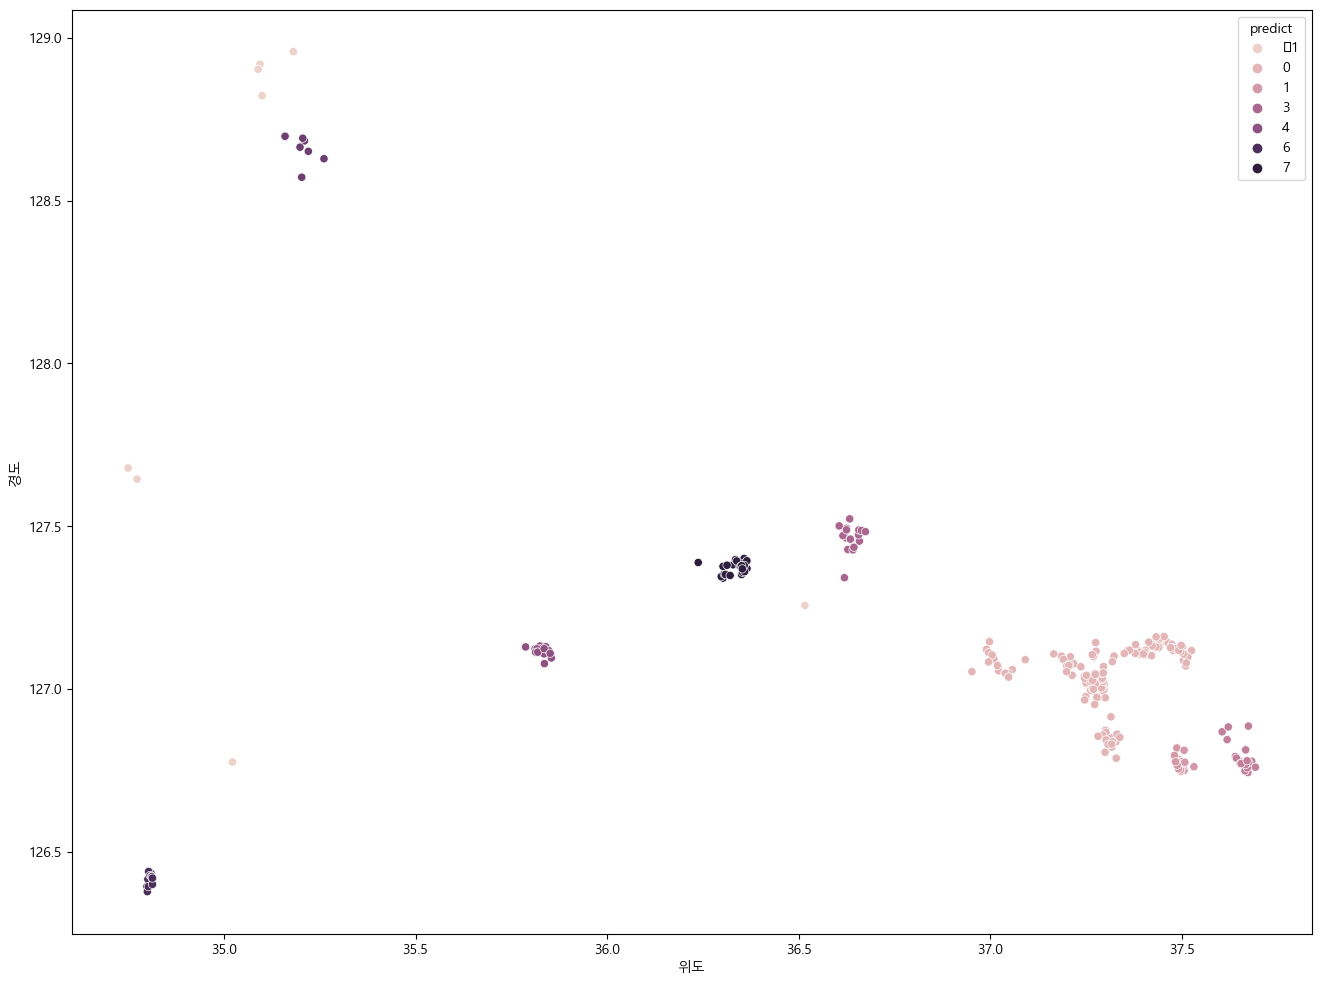

In [26]:
plt.figure(figsize=(16, 12))
sns.scatterplot(data=x, x="위도", y="경도", hue="predict")
plt.show()

In [27]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps = 346, algorithm = 'auto')
feature = area[['위도', '경도']]
dbscan_predict = pd.DataFrame(model.fit_predict(feature))
dbscan_predict.columns = ['predict']
x = pd.concat([feature.reset_index(), dbscan_predict.reset_index()], axis = 1)
x.drop(['index'], axis = 1, inplace = True)

In [50]:
feature = cctv[['위도', '경도']]
kmeans_model = KMeans(n_clusters = 379, algorithm = 'auto')
kmeans_model.fit(feature)
kmeans_predict = pd.DataFrame(kmeans_model.predict(feature))
kmeans_predict.columns = ['predict']

In [56]:
kmeans_predict

,predict
0,235
1,189
2,108
3,186
4,43
...,...
8326,195
8327,195
8328,208
8329,218


In [62]:
xx = pd.concat([feature.reset_index(drop=True), kmeans_predict], axis = 1)

In [63]:
cent = xx.groupby("predict").mean()
cent

,위도,경도
predict,,
0,35.846158,127.078508
1,35.231942,128.584641
2,36.499728,127.423012
3,35.022815,126.780480
4,34.784507,127.696189
...,...,...
374,35.250868,128.614464
375,35.851005,127.108388
376,34.799980,126.373207


In [65]:
area[['위도', '경도']]

,위도,경도
0,37.291866,127.028769
1,37.295078,127.016335
2,37.249954,127.018655
3,37.251760,127.041167
4,37.269280,126.993927
...,...,...
374,37.492502,127.118637
375,37.510616,127.070612
376,37.512052,127.079645
377,37.470768,127.126755


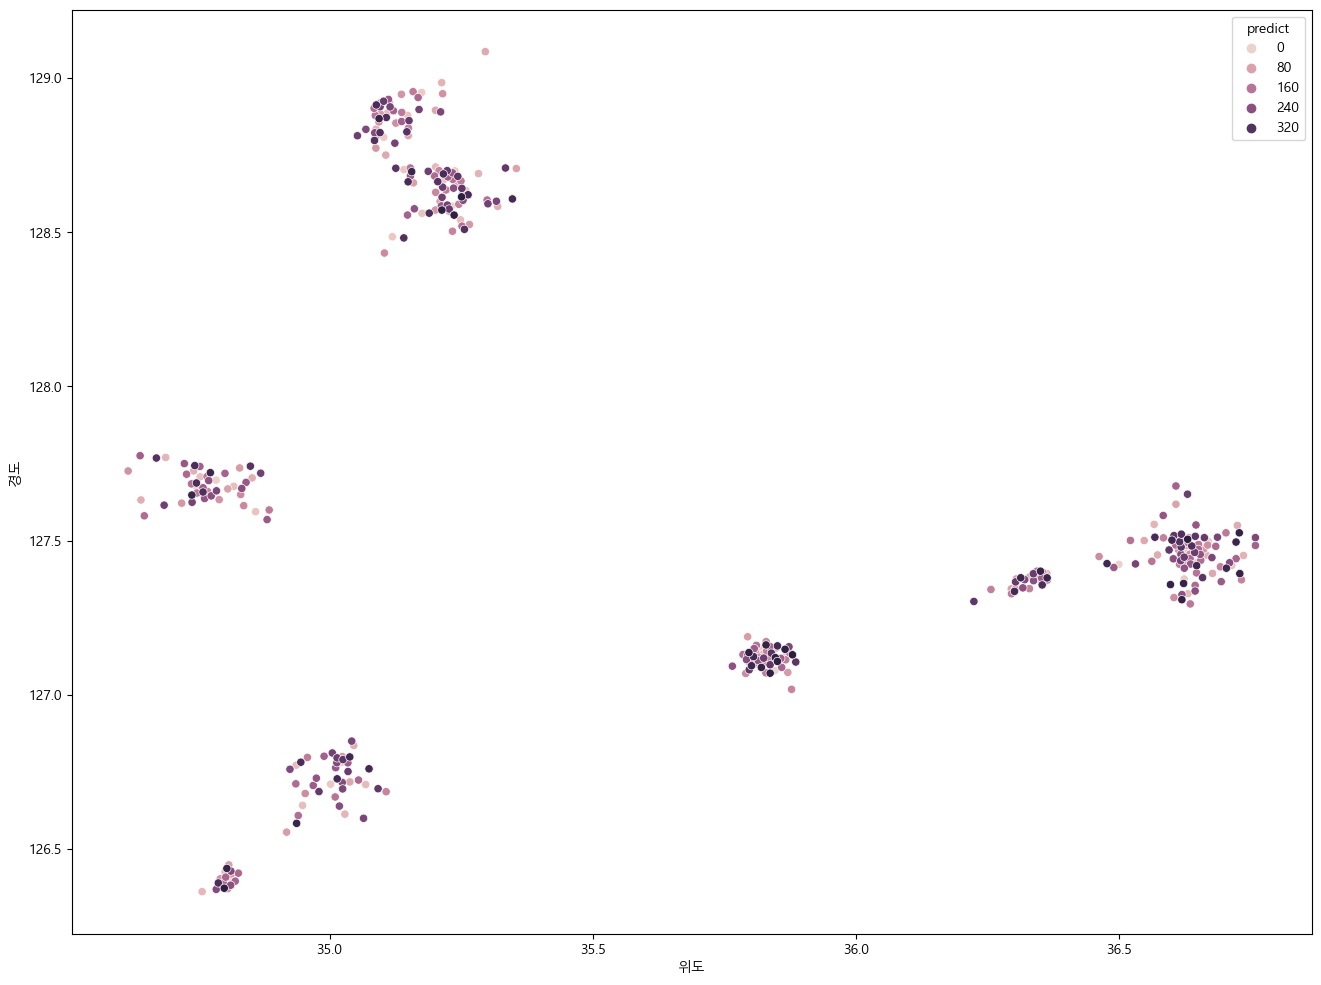

In [66]:
plt.figure(figsize=(16, 12))
sns.scatterplot(data=cent, x="위도", y="경도", hue="predict")
plt.show()

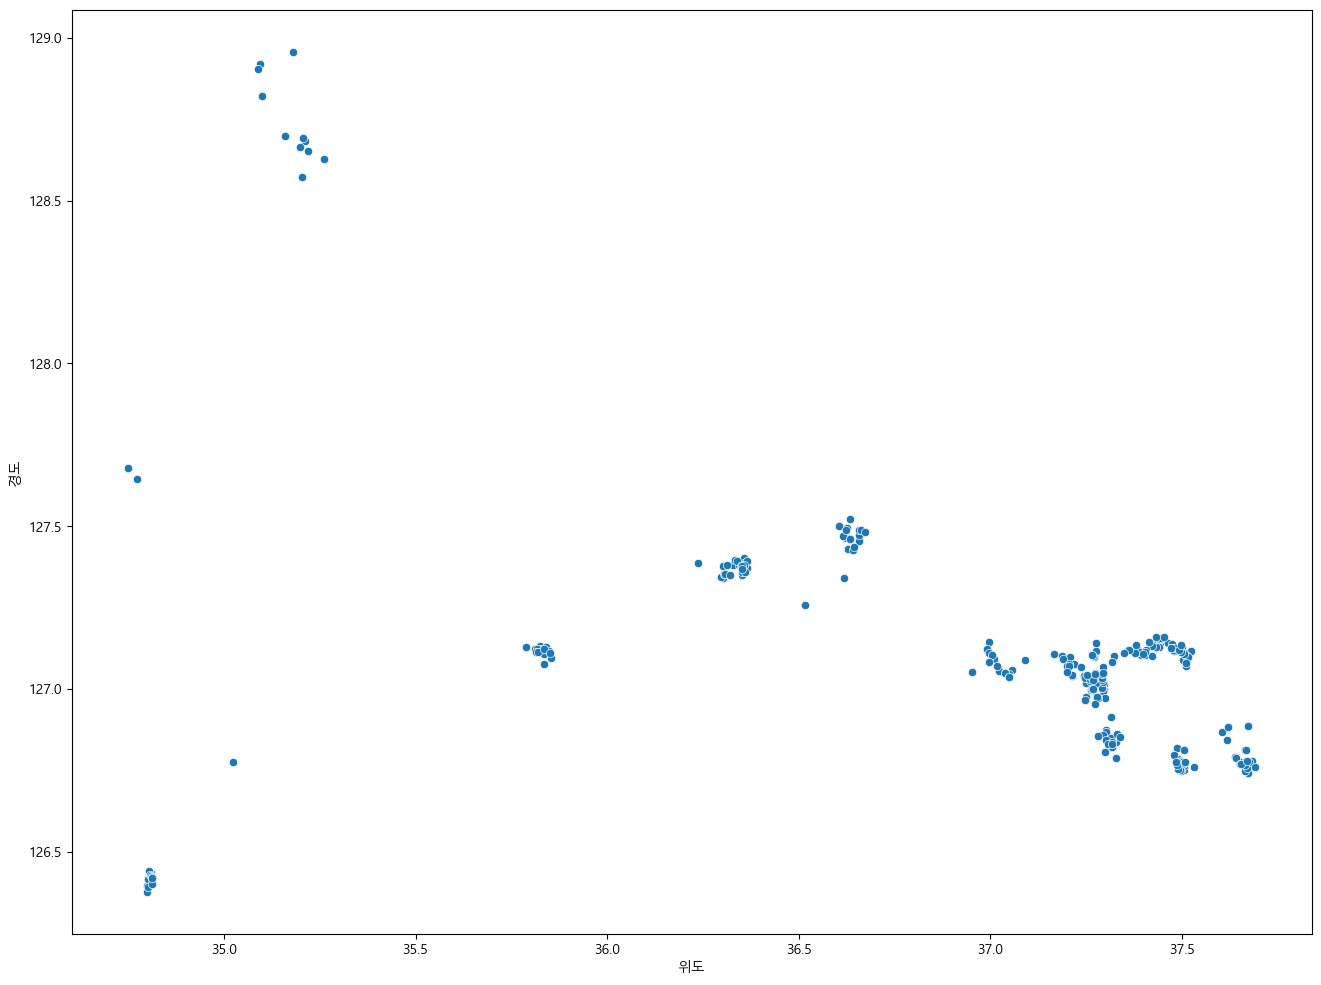

In [68]:
plt.figure(figsize=(16, 12))
sns.scatterplot(data=area[['위도', '경도']], x="위도", y="경도")
plt.show()